In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
# import cv2
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib
# import sklearn
from keras import layers,losses #,Sequential,metrics
from keras.models import Model
import Utils
# from tensorflow.keras.layers import Layer
# from tensorflow.keras import optimizers
# from tensorflow.keras.optimizers.experimental import SGD
# from tensorflow.image import ssim

from Reconstruction import Reconstruction as M_PMRNN
from ViTReconstruction import Reconstruction as MViT_PMRNN
from DPMRNN import Reconstruction as DPMRNN 

In [2]:
#from tensorflow.python.compiler.tensorrt import trt_convert as trt
device = tf.config.list_physical_devices("GPU")
print(device)  # Check if GPU devices are visible
print(tf.test.is_built_with_cuda())  # Check if TensorFlow is built with CUDA support
#print(trt.trt_utils._pywrap_py_utils.get_linked_tensorrt_version())

tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
X_test=np.load('X_test.npy')
X_test.shape
first  = X_test[0]
Topredict = first[1:]
test = first[:-1]

# C-3DP

In [4]:
M_3D_PMRNN = M_PMRNN()
M_3D_PMRNN.summary()
M_3D_PMRNN.compile()


Instructions for updating:
Colocations handled automatically by placer.
Model: "learned_prior"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
learned_prior_input (InputLa [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 32)      128       
_______________________________________________

In [5]:
M_3D_PMRNN = M_PMRNN.load(save_folder=f"M-3D-PMRNN-trained")

# ViT

In [6]:
ViT_PMRNN = MViT_PMRNN()
ViT_PMRNN.summary()
ViT_PMRNN.compile()


Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_encoder (PatchEncoder) (None, 256, 256)          131328    
_________________________________________________________________
transformer_encoder (Transfo (None, 256, 256)          921600    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
Total params: 9,449,920
Trainable params: 9,449,920
Non-trainable params: 0
_________________________________________________________________
Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_encoder (PatchEncoder) (None, 256, 256)          131328    
__________

In [7]:
ViT_PMRNN = MViT_PMRNN.load(save_folder=f"MViT-3D-PMRNN-final")

# 3D-PMRNN

In [8]:
D_PMRNN = DPMRNN()
D_PMRNN.summary()
D_PMRNN.compile()


Model: "learned_prior"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
learned_prior_input (InputLa [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_95 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_96 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 64, 64, 32)      

In [9]:
D_PMRNN = DPMRNN.load(save_folder=f"3D-PMRNN")

In [11]:
from skimage.metrics import mean_squared_error

def porosity(im):
    threshold = 0.5  # Adjust the threshold as needed

    # Calculate the porosity using NumPy operations
    porosity = 1 - np.mean(im <= threshold)
    return porosity


def calculate_mae(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length.")
    mae = [abs(y1 - y2) for y1, y2 in zip(list1, list2)] 
    return mae

def calculate_mse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length.")
    mse = [mean_squared_error(img1, img2) for img1, img2 in zip(list1, list2)]
    return mse

# Testing C-3DP

In [10]:
testing_M3DP = []
inputLayer = first[0]
print(inputLayer.shape)
# for i in range(len(first)-1):
for i in range(len(test)):
    learned = M_3D_PMRNN.learnedPrior.predict(inputLayer.reshape(1,256,256,1))
    testing_M3DP.append(M_3D_PMRNN.Generate.predict([inputLayer.reshape(1,256,256,1),learned.reshape(1,1,64)],steps=1))
    inputLayer = testing_M3DP[-1]

(256, 256, 1)


d:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


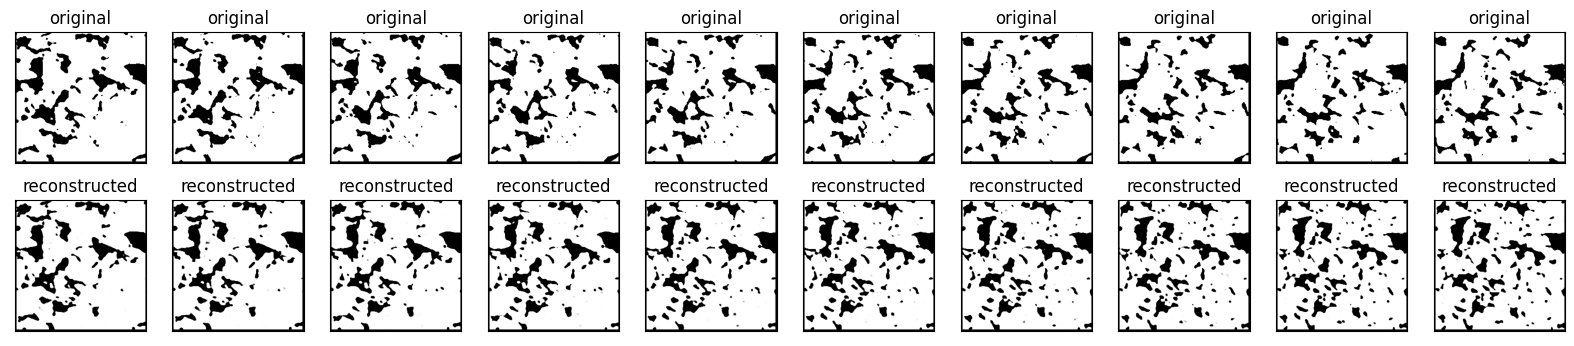

In [95]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing_M3DP[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [96]:
pore_testing_M3DP = [porosity(im) for im in testing_M3DP]
#print(pore_testing[:10])

pore = [porosity(im) for im in Topredict]
#print(pore_MPMRNN[:10])

# print(Topredict.shape)
# print(np.array(testing).shape)
testing_M3DP = np.array(testing_M3DP).reshape(249,256,256,1)

mae_MPMRNN = calculate_mae(pore_testing_M3DP,pore)
mse_MPMRNN = calculate_mse(Topredict,testing_M3DP)

# print(len(mae_MPMRNN))
# print(len(mse_MPMRNN))

249
249


# Testing ViT-3DP

In [11]:
testing_vit = []
inputLayer = first[0]
print(inputLayer.shape)
# for i in range(len(first)-1):
for i in range(len(test)):
    learned = ViT_PMRNN.learnedPrior.predict(inputLayer.reshape(1,256,256,1))
    testing_vit.append(ViT_PMRNN.Generate.predict([inputLayer.reshape(1,256,256,1),learned.reshape(1,1,256)],steps=1))
    inputLayer = testing_vit[-1]

(256, 256, 1)


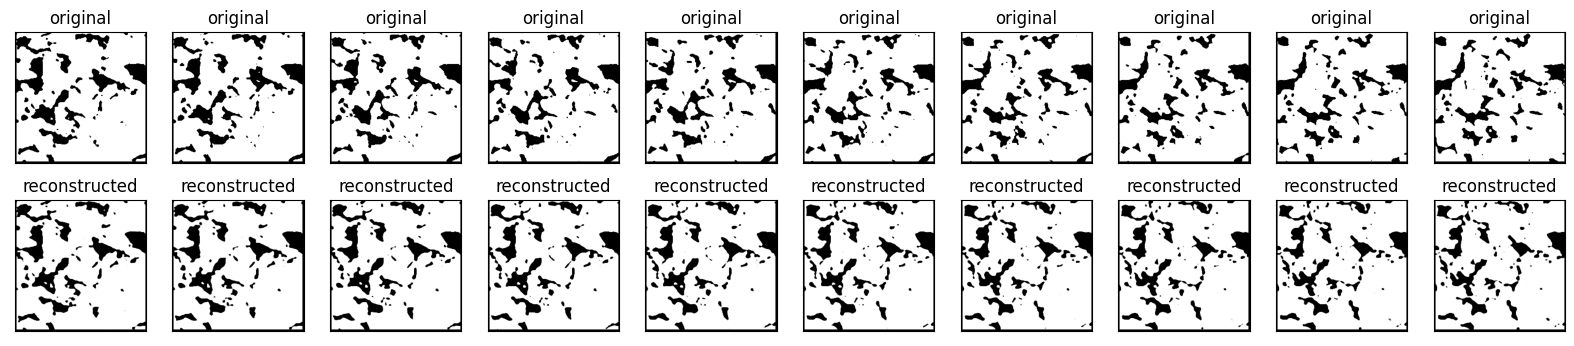

In [98]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing_vit[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [99]:


pore_ViT_PMRNN= [porosity(im) for im in testing_vit]
#print(pore_MPMRNN[:10])

# print(Topredict.shape)
# print(np.array(testing).shape)
testing_vit = np.array(testing_vit).reshape(249,256,256,1)

mae_ViT_PMRNN = calculate_mae(pore,pore_ViT_PMRNN)
mse_ViT_PMRNN = calculate_mse(Topredict,testing_vit)

# print(mae_ViT_PMRNN)
# print(mse_ViT_PMRNN)

[0.0025177001953125, 0.0031890869140625, 0.00396728515625, 0.012359619140625, 0.0136871337890625, 0.0108795166015625, 0.0083465576171875, 0.0083770751953125, 0.01007080078125, 0.00775146484375, 0.0052947998046875, 0.005035400390625, 0.008758544921875, 0.0084228515625, 0.008331298828125, 0.0082550048828125, 0.0021820068359375, 0.003936767578125, 0.0059661865234375, 0.0069122314453125, 0.008270263671875, 0.0142822265625, 0.017608642578125, 0.0189666748046875, 0.020263671875, 0.018157958984375, 0.01263427734375, 0.0093231201171875, 0.00457763671875, 0.002655029296875, 0.0025634765625, 0.0051727294921875, 0.0080718994140625, 0.0099029541015625, 0.0112762451171875, 0.011199951171875, 0.008544921875, 0.0082244873046875, 0.012359619140625, 0.005889892578125, 0.006683349609375, 0.0035552978515625, 0.001434326171875, 0.000946044921875, 0.0027923583984375, 0.0033721923828125, 0.0003509521484375, 0.00146484375, 0.001739501953125, 0.0096282958984375, 0.016693115234375, 0.0213775634765625, 0.021667

# Testing 3D-PMRNN

In [12]:
testing_3DP = []
inputLayer = first[0]
print(inputLayer.shape)
# for i in range(len(first)-1):
for i in range(len(test)):
    learned = D_PMRNN.learnedPrior.predict(inputLayer.reshape(1,256,256,1))
    testing_3DP.append(D_PMRNN.Generate.predict([inputLayer.reshape(1,256,256,1),learned.reshape(1,1,64)],steps=1))
    inputLayer = testing_3DP[-1]

(256, 256, 1)


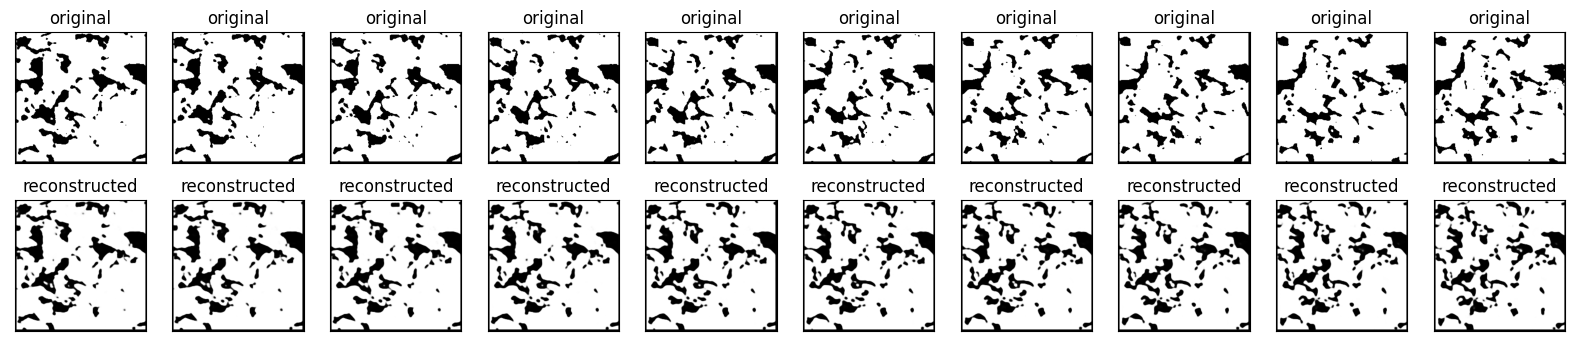

In [102]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing_3DP[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [13]:

pore_D_PMRNN= [porosity(im) for im in testing_3DP]
#print(pore_MPMRNN[:10])

# print(Topredict.shape)
# print(np.array(testing).shape)
testing_3DP = np.array(testing_3DP).reshape(249,256,256,1)

mae_D_PMRNN = calculate_mae(pore,pore_D_PMRNN)
mse_D_PMRNN = calculate_mse(Topredict,testing_3DP)

print(mae_D_PMRNN)
print(mse_D_PMRNN)

NameError: name 'porosity' is not defined

In [104]:
print(mae_ViT_PMRNN)
print(mae_D_PMRNN)
print(mae_MPMRNN)

[0.0025177001953125, 0.0031890869140625, 0.00396728515625, 0.012359619140625, 0.0136871337890625, 0.0108795166015625, 0.0083465576171875, 0.0083770751953125, 0.01007080078125, 0.00775146484375, 0.0052947998046875, 0.005035400390625, 0.008758544921875, 0.0084228515625, 0.008331298828125, 0.0082550048828125, 0.0021820068359375, 0.003936767578125, 0.0059661865234375, 0.0069122314453125, 0.008270263671875, 0.0142822265625, 0.017608642578125, 0.0189666748046875, 0.020263671875, 0.018157958984375, 0.01263427734375, 0.0093231201171875, 0.00457763671875, 0.002655029296875, 0.0025634765625, 0.0051727294921875, 0.0080718994140625, 0.0099029541015625, 0.0112762451171875, 0.011199951171875, 0.008544921875, 0.0082244873046875, 0.012359619140625, 0.005889892578125, 0.006683349609375, 0.0035552978515625, 0.001434326171875, 0.000946044921875, 0.0027923583984375, 0.0033721923828125, 0.0003509521484375, 0.00146484375, 0.001739501953125, 0.0096282958984375, 0.016693115234375, 0.0213775634765625, 0.021667

In [105]:
print(mse_ViT_PMRNN)
print(mse_D_PMRNN)
print(mse_MPMRNN)

[0.028511812621479074, 0.05580352877128512, 0.07868131026078413, 0.1012335419467386, 0.11833507391388902, 0.13303059966607844, 0.1446541574517123, 0.15257330209182535, 0.1569816013350801, 0.16473402134477816, 0.16954523896846896, 0.17537739576294903, 0.17791652311080988, 0.18371500958059594, 0.18864158112756357, 0.19378878549563217, 0.20461470309283153, 0.21590568453965095, 0.22256626513247296, 0.22905390156442565, 0.23567992976823987, 0.24062930488312662, 0.24088891905821674, 0.2401245147409689, 0.24134996147759316, 0.24001132231248679, 0.23420509016375182, 0.23141465369368708, 0.23179963862725508, 0.23053209578375147, 0.2316485843699035, 0.2347699836597153, 0.23842025813308598, 0.24155847998171093, 0.2420005822169881, 0.2412164415967886, 0.23857588454531609, 0.23870617363516206, 0.24229430064012894, 0.24063489367230576, 0.24282829071858397, 0.24235156678896982, 0.2407254485717013, 0.23720029816400048, 0.2342462739443742, 0.234995547164364, 0.23773893212320998, 0.24143545581274362, 0.

# Print a slice of the reconstructed voxel with each architecture

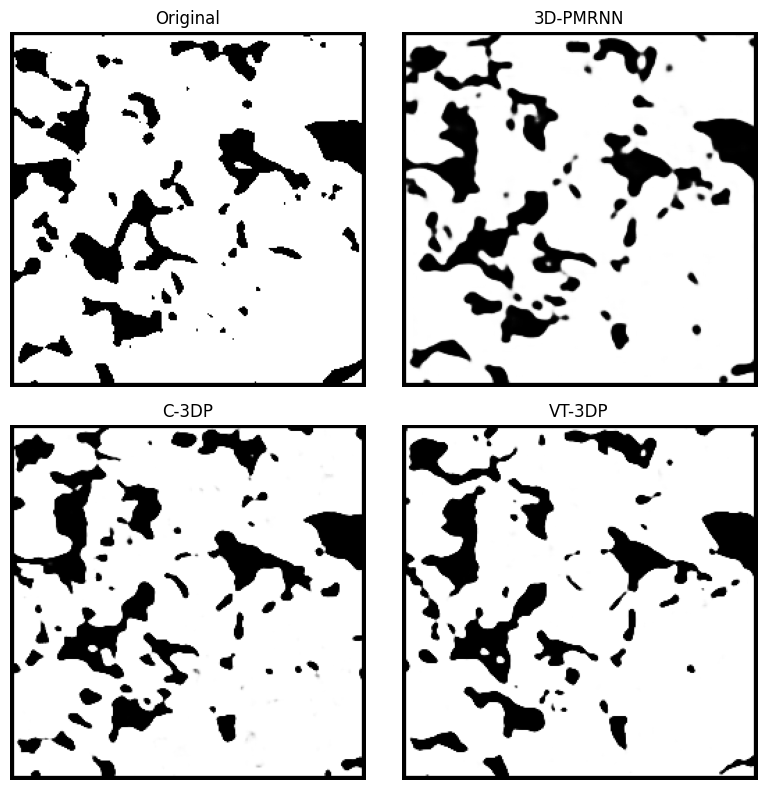

In [22]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8,8))


# Display the images in each subplot
axs[0, 0].imshow(Topredict[3].reshape(256,256,1))
axs[0, 0].set_title('Original')
axs[0, 1].imshow(testing_3DP[3].reshape(256,256,1))
axs[0, 1].set_title('3D-PMRNN')
axs[1, 0].imshow(testing_M3DP[3].reshape(256,256,1))
axs[1, 0].set_title('C-3DP')
axs[1, 1].imshow(testing_vit[3].reshape(256,256,1))
axs[1, 1].set_title('VT-3DP')

# Remove the axis labels
for ax in axs.flat:
    
    ax.axis('off')

# Adjust the layout and spacing between subplots
plt.gray()
plt.tight_layout()

# Show the plot
plt.show()

# Plot MSE for each architecture

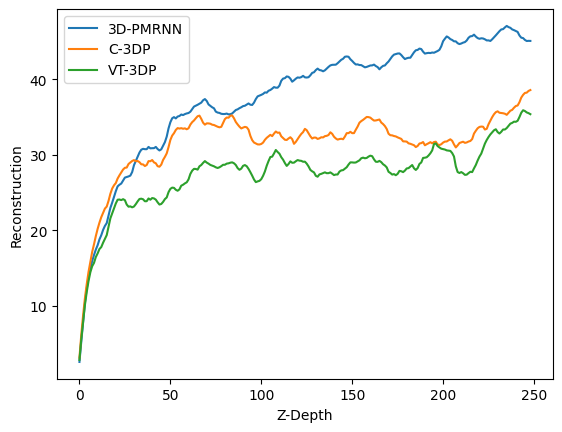

In [106]:
# Create the plot
# plt.plot(range(len(testing)), pore_testing, label='original')
plt.plot(range(len(testing_3DP)), [ i * 100 for i in mse_D_PMRNN] , label='3D-PMRNN')
plt.plot(range(len(testing_3DP)), [ i * 100 for i in mse_MPMRNN] , label='C-3DP')
plt.plot(range(len(testing_3DP)), [ i * 100 for i in mse_ViT_PMRNN], label='VT-3DP')
# plt.plot(range(len(testing)), pore_ViT_PMRNN, label='MViTPMRNN')

# Add labels and a legend
plt.xlabel('Z-Depth')
plt.ylabel('Reconstruction')
plt.legend()

# Display the plot
plt.show()

# Plot MSE for each architecture

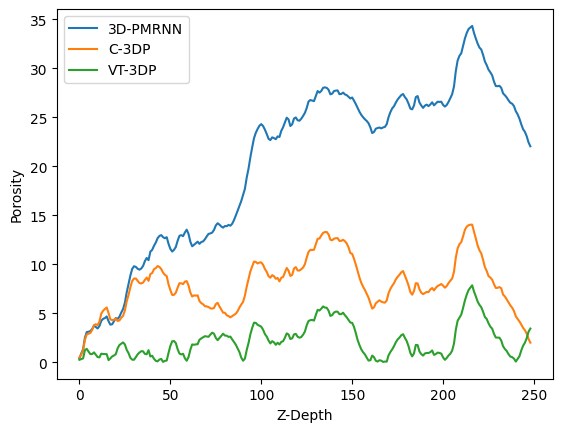

In [107]:
# Create the plot
# plt.plot(range(len(testing)), pore_testing, label='original')
plt.plot(range(len(testing_3DP)), [ i * 100 for i in mae_D_PMRNN] , label='3D-PMRNN')
plt.plot(range(len(testing_3DP)), [ i * 100 for i in mae_MPMRNN] , label='C-3DP')
plt.plot(range(len(testing_3DP)), [ i * 100 for i in mae_ViT_PMRNN], label='VT-3DP')
# plt.plot(range(len(testing)), pore_ViT_PMRNN, label='MViTPMRNN')

# Add labels and a legend
plt.xlabel('Z-Depth')
plt.ylabel('Porosity')
plt.legend()

# Display the plot
plt.show()

# Save the reconstructed voxel 

In [ ]:
final = np.array(testing_vit, np.float32).reshape(250, 256, 256)
file_path = "my_array.npy"
np.save("file", final)
final.tofile(file_path)
